In [1]:
from importlib import reload
import tensorflow as tf
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import utils_v2
reload(utils_v2)
from utils_v2 import *

import MintDQNAgent
reload(MintDQNAgent)
from MintDQNAgent import MintDQNAgent

In [3]:
import datetime

In [4]:
agent = MintDQNAgent(cash_supply=5000, epsilon_decay=0.9)

Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
# features
agent.external_states

['USDT_BTC_high',
 'USDT_BTC_low',
 'USDT_BTC_close',
 'USDT_BTC_open',
 'USDT_BTC_weighted_mean',
 'USDT_BTC_volatility',
 'USDT_BTC_pctChange',
 'USDT_BTC_open_label',
 'USDT_BTC_pctChange_label',
 'USDT_BTC_volatility_label']

In [31]:
import matplotlib.pyplot as plt

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def plot_test(start_time, end_time):

    if end_time is None: # default: one day
        end_time = start_time + agent.env.time_delta * 24

    df = agent.env.df
    df = df.loc[df.index >= start_time]
    df = df.loc[df.index <= end_time]
    prices = df['USDT_BTC_open']
#     print(prices.shape)
#     print(smooth(prices))
    
    actions = agent.test_actions
    actions = actions[actions.index >= start_time]
    actions = actions[actions.index < end_time]

    fig, ax1 = plt.subplots(figsize = (15, 8))

    ax1.plot(prices.index, prices, 'b-')
    ax1.set_ylabel('Price', color='b', fontsize=15)
    ax1.tick_params('y', colors='b', labelsize=15)

    hold = actions[actions == 1]
    buy = actions[actions == 2]
    sell = actions[actions == 0]


    
    sm =  smooth(prices,24)[12:len(prices.index)+12]
    import numpy as np
    from scipy.signal import argrelextrema

    local_minima = argrelextrema(sm,np.less) 
    local_maxima = argrelextrema(sm,np.greater)
    turning = np.concatenate((local_minima[0],local_maxima[0]),axis=0)
    turning = np.append(turning,0)
    turning = np.append(turning,len(prices.index) - 1)
    turning.sort()
    sell_first = True
    if (prices[0] < prices[1]):
        sell_first = False
    l_turning = list(turning)
    edge = []
    edge.append(0)
    for i in range(len(l_turning) - 1):
        edge.append((l_turning[i] + l_turning[i + 1])//2)
    edge.append(len(prices.index) - 1)
    
    good_action = []
    cur_action = 0 # sell
    last_edge = 0
    if (not sell_first):
        cur_action = 2 # buy
    for i in range(1,len(edge)):
        target_edge = edge[i]
        for j in np.arange(last_edge,target_edge,1):
            good_action.append(cur_action)
        cur_action = 2 - cur_action
        last_edge = target_edge
#     print(good_action)
#     print(len(good_action))
# #     print(actions)
#     print(len(actions))
#     print(len(prices.index))
    good_action_df = pd.DataFrame()
    good_action_df["good_action"] = good_action
    good_action_df.index = actions.index


    
    good_buy = actions[(actions == 2) & (actions == good_action)]
    bad_buy = actions[(actions== 2) & (actions != good_action)]
    good_sell = actions[(actions == 0) & (actions == good_action)]
    bad_sell = actions[(actions== 0) & (actions != good_action)] 
#     print(good_buy)
#     print(bad_buy)
#     print(buy)
#     print(good_sell)
#     print(bad_sell)
#     print(sell)
        
    ax2 = ax1.twinx()
    ax2.scatter(hold.index, hold, c='blue', label='HOLD')
    ax2.scatter(good_buy.index, good_buy, c='green', marker = 'o',label='GOOD_BUY')
    ax2.scatter(bad_buy.index, bad_buy, c='green',marker = 'x', label='BAD_BUY')
    ax2.scatter(good_sell.index, good_sell, c='red', marker = 'o', label='GOOD_SELL')
    ax2.scatter(bad_sell.index, bad_sell, c='red', marker = 'x', label='BAD_SELL')
    ax2.set_yticks([])
    ax2.legend(loc=1, fontsize=15)
        
    
    ax3 = ax1.twinx()
    ax3.plot(prices.index,sm, 'r-')
    ax3.tick_params('y_smooth', colors='r', labelsize=15)

#     ax4 = ax1.twinx()
#     ax4.scatter(hold.index, holdg, c='blue', label='HOLD')
#     ax4.scatter(buy.index, buyg, c='green', label='BUY')
#     ax4.scatter(sell.index, sellg, c='red', label='SELL')
#     ax4.set_yticks([])
#     ax4.legend(loc=1, fontsize=15)


    plt.xlim(actions.index[0], actions.index[-1])       

    plt.show()

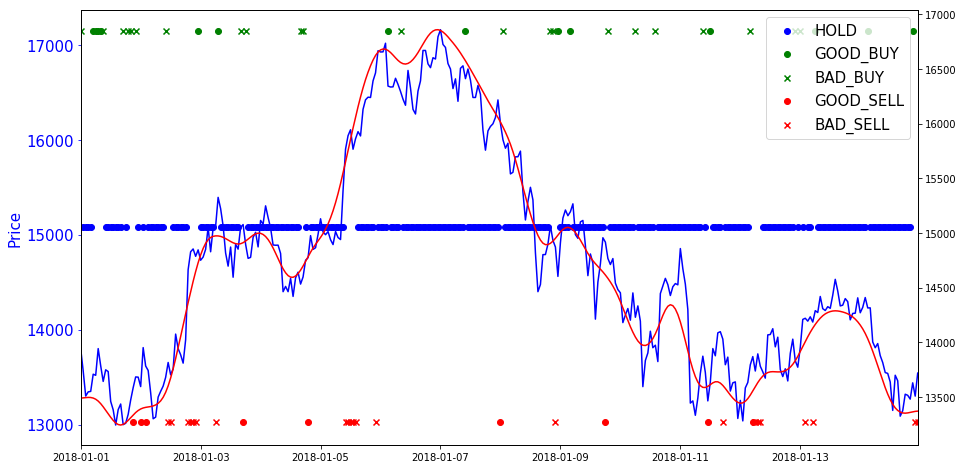

In [32]:
plot_test(test_start, datetime.datetime(2018,1,15,0))

In [43]:
start_time = datetime.datetime(2017,12,1,0)
end_time = datetime.datetime(2018,1,1,0)
df = agent.env.df
df = df.loc[df.index >= start_time]
df = df.loc[df.index <= end_time]
print(df['USDT_BTC_open'])


time
2017-12-01 00:00:00     9907.760000
2017-12-01 01:00:00     9830.000000
2017-12-01 02:00:00     9730.904835
2017-12-01 03:00:00     9779.323607
2017-12-01 04:00:00     9659.099502
2017-12-01 05:00:00     9838.000000
2017-12-01 06:00:00     9568.000000
2017-12-01 07:00:00     9420.000000
2017-12-01 08:00:00     9541.000000
2017-12-01 09:00:00     9793.320838
2017-12-01 10:00:00    10013.000000
2017-12-01 11:00:00     9779.152492
2017-12-01 12:00:00     9963.372452
2017-12-01 13:00:00    10149.000000
2017-12-01 14:00:00    10649.000000
2017-12-01 15:00:00    10490.000000
2017-12-01 16:00:00    10519.496952
2017-12-01 17:00:00    10539.526074
2017-12-01 18:00:00    10358.316735
2017-12-01 19:00:00    10440.000000
2017-12-01 20:00:00    10544.000000
2017-12-01 21:00:00    10670.000000
2017-12-01 22:00:00    10800.000000
2017-12-01 23:00:00    10700.000000
2017-12-02 00:00:00    10699.888888
2017-12-02 01:00:00    10879.217323
2017-12-02 02:00:00    11040.000170
2017-12-02 03:00:00    

In [73]:
prices= df['USDT_BTC_open']
prices[0]

9907.76

In [65]:
smooth(df['USDT_BTC_open'],24)

array([10046.11710514,  9978.26362939,  9916.85032451,  9863.35391579,
        9818.99501013,  9784.5715836 ,  9760.53872234,  9746.2735477 ,
        9739.49494888,  9737.40288859,  9737.24285586,  9737.42784334,
        9737.42784334,  9737.24285586,  9737.40288859,  9739.49494888,
        9746.2735477 ,  9760.53872234,  9784.5715836 ,  9818.99501013,
        9863.35391579,  9916.85032451,  9978.26362939, 10046.11710514,
       10118.21961507, 10191.90348273, 10264.95784238, 10335.84857979,
       10403.57543415, 10467.0508585 , 10525.30123892, 10578.39530453,
       10626.86745439, 10671.06267648, 10711.02431734, 10747.48664545,
       10781.72065505, 10814.25891986, 10844.68962706, 10872.24954413,
       10896.26825891, 10915.7963187 , 10930.41108769, 10940.51790232,
       10946.70055175, 10949.45488059, 10949.12792332, 10946.47591098,
       10942.62761665, 10938.30486599, 10933.55009671, 10928.16619136,
       10922.34948715, 10916.7699855 , 10912.23131002, 10909.5878677 ,
      

In [75]:
import numpy as np
from scipy.signal import argrelextrema

a = argrelextrema(smooth(df['USDT_BTC_open'],24)[0:700],np.less)

In [78]:
b = argrelextrema(smooth(df['USDT_BTC_open'],24), np.greater)

In [84]:
type(a[0])

numpy.ndarray

In [90]:
a

(array([ 10,  13,  55,  86,  99, 194, 234, 283, 324, 373, 424, 438, 472,
        490, 531, 580, 605, 675]),)

In [94]:
turning = np.concatenate((a[0],b[0]),axis=0)
turning = np.sort(turning)
turning = np.append(turning,0)
turning = np.append(turning,700)
turning

array([ 10,  12,  13,  45,  55,  76,  86,  91,  99, 181, 194, 204, 234,
       273, 283, 289, 324, 364, 373, 406, 424, 431, 438, 445, 472, 481,
       490, 497, 531, 556, 580, 602, 605, 641, 675, 690, 755,   0, 700])

In [80]:
turning.sort()

AttributeError: 'tuple' object has no attribute 'sort'

In [64]:
argrelextrema(smooth(df['USDT_BTC_open'],24)[0:700],np.greater)

(array([ 12,  45,  76,  91, 181, 204, 273, 289, 364, 406, 431, 445, 481,
        497, 556, 602, 641, 690]),)

<function matplotlib.pyplot.show>

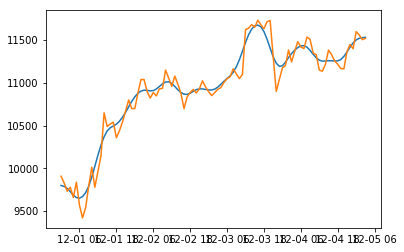

In [96]:
l = 100
plt.plot(df['USDT_BTC_open'].index[0:l],smooth(df['USDT_BTC_open'],12)[6:l+6])
plt.plot(df['USDT_BTC_open'].index[0:l],df['USDT_BTC_open'][0:l])
plt.show

# Train (2017-12-01 ~ 2018-01-01)

In [6]:
train_start = datetime.datetime(2017,12,1,0)
train_end = datetime.datetime(2018,1,1,0)

sess = tf.Session()
agent.train(sess, start_time = train_start, end_time = train_end, num_episodes=10, verbose=False) # SHOULD USE MORE EPOCHS!!!

Training from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

episode: 1/10, returns: -4.6, epsilon: 1.0
episode: 2/10, returns: -8.3, epsilon: 1.0
episode: 3/10, returns: 8.6, epsilon: 1.0
episode: 4/10, returns: -1.5e+01, epsilon: 0.9
episode: 5/10, returns: 1.2e+01, epsilon: 0.81
episode: 6/10, returns: 4.4, epsilon: 0.73
episode: 7/10, returns: 0.83, epsilon: 0.66
episode: 8/10, returns: 8.5, epsilon: 0.59
episode: 9/10, returns: 5.1, epsilon: 0.53
episode: 10/10, returns: -2.4, epsilon: 0.48


AttributeError: 'QValue_NN' object has no attribute 'save'

# Sanity check

In [7]:
agent.env.set_current_time(datetime.datetime(2017,12,1,0))

In [8]:
agent.env.step()
state = agent.env.getStatesSequence() + agent.portfolio.getStates()
state -= agent.state_mean
print(state[:10])

agent.model.predict(sess, state)

[ 1.69867702e+03  1.67491955e+03  1.68375889e+03  1.58541258e+03
  1.68917714e+03  4.58929900e-03  9.21132571e-03 -5.01621771e-01
  1.49171203e+00  1.09100217e+00]


array([[-7.660824 , -7.1847277, -6.8827567]], dtype=float32)

# Test on (2017-09-01 ~ 2018,1,1,0) Cheating...

In [13]:
test_start = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

Current time: 2017-12-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:9896.844
After buying: coin bought:0.051, transaction fees:1.250, coin now:0.051, cash now:4498.750
Action end:  Action.BUY , Total value now: 4991.996.  , Return since entry: -0.160 %

Current time: 2017-12-02 00:00:00
Action start: Action.HOLD , Total value before action: 5245.475907810784
Action end:  Action.HOLD , Total value now: 5245.476.  , Return since entry: 4.910 %

Current time: 2017-12-03 00:00:00
Action start: Action.HOLD , Total value before action: 5201.75836761115
Action end:  Action.HOLD , Total value now: 5201.758.  , Return since entry: 4.035 %

Current time: 2017-12-04 00:00:00
Action start: Action.HOLD , Total value before action: 5357.257009653504
Action end:  Action.HOLD , Total value now: 5357.257.  , Return since entry: 7.145 %

Current time: 201

744
744
745


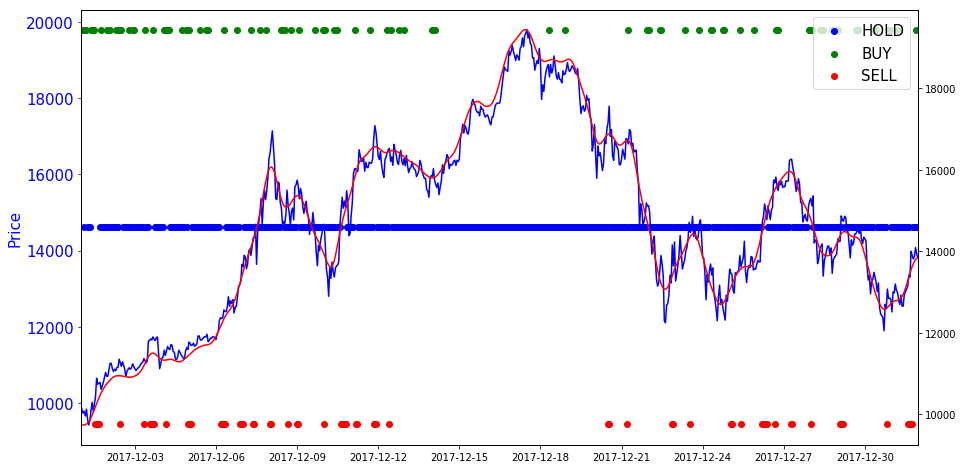

In [14]:
plot_test(test_start, test_end)

# Test on unseen time period (2018-01-01 ~ )

In [15]:
test_start = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, verbose=True)

Testing from  2018-01-01 00:00:00  to 2018-04-14 02:00:00 :  ~ 103 days

Current time: 2018-01-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:13656.235
After buying: coin bought:0.037, transaction fees:1.250, coin now:0.037, cash now:4498.750
Action end:  Action.BUY , Total value now: 4991.996.  , Return since entry: -0.160 %

Current time: 2018-01-02 00:00:00
Action start: Action.SELL , Total value before action: 5014.8165721651185
Before selling: coin:0.219, cash:2009.568, sell price:13717.085
After selling: coin sold:0.022, transaction fees:0.751, coin now:0.197, cash now:2309.342
Action end:  Action.SELL , Total value now: 5014.065.  , Return since entry: 0.281 %

Current time: 2018-01-03 00:00:00
Action start: Action.HOLD , Total value before action: 5143.271740170289
Action end:  Action.HOLD , Total value now: 5143.272.  , Return since entry: 2.865 %

Current time: 2018-01-04 00:00:00
Action start: Acti

Current time: 2018-02-06 00:00:00
Action start: Action.HOLD , Total value before action: 3131.893499617019
Action end:  Action.HOLD , Total value now: 3131.893.  , Return since entry: -37.362 %

Current time: 2018-02-07 00:00:00
Action start: Action.SELL , Total value before action: 3243.190032670674
Before selling: coin:0.103, cash:2466.036, sell price:7558.252
After selling: coin sold:0.010, transaction fees:0.194, coin now:0.093, cash now:2543.557
Action end:  Action.SELL , Total value now: 3242.996.  , Return since entry: -35.140 %

Current time: 2018-02-08 00:00:00
Action start: Action.HOLD , Total value before action: 3253.8768023849834
Action end:  Action.HOLD , Total value now: 3253.877.  , Return since entry: -34.922 %

Current time: 2018-02-09 00:00:00
Action start: Action.BUY , Total value before action: 3241.0174832128196
Before buying: coin:0.250, cash:1268.518, buy price:7983.609
After buying: coin bought:0.016, transaction fees:0.317, coin now:0.266, cash now:1141.349
Ac

Current time: 2018-03-05 00:00:00
Action start: Action.SELL , Total value before action: 3319.971686280852
Before selling: coin:0.068, cash:2539.295, sell price:11396.970
After selling: coin sold:0.007, transaction fees:0.195, coin now:0.062, cash now:2617.168
Action end:  Action.SELL , Total value now: 3319.777.  , Return since entry: -33.604 %

Current time: 2018-03-06 00:00:00
Action start: Action.HOLD , Total value before action: 3273.4485101324676
Action end:  Action.HOLD , Total value now: 3273.449.  , Return since entry: -34.531 %

Current time: 2018-03-07 00:00:00
Action start: Action.SELL , Total value before action: 3204.280048932472
Before selling: coin:0.127, cash:1829.578, sell price:10787.145
After selling: coin sold:0.013, transaction fees:0.344, coin now:0.115, cash now:1966.704
Action end:  Action.SELL , Total value now: 3203.936.  , Return since entry: -35.921 %

Current time: 2018-03-08 00:00:00
Action start: Action.SELL , Total value before action: 3077.832701194153

Current time: 2018-04-01 00:00:00
Action start: Action.BUY , Total value before action: 2386.6447532091406
Before buying: coin:0.147, cash:1365.612, buy price:7042.240
After buying: coin bought:0.019, transaction fees:0.341, coin now:0.166, cash now:1228.709
Action end:  Action.BUY , Total value now: 2384.459.  , Return since entry: -52.311 %

Current time: 2018-04-02 00:00:00
Action start: Action.SELL , Total value before action: 2377.4166604322577
Before selling: coin:0.096, cash:1710.278, sell price:6964.713
After selling: coin sold:0.010, transaction fees:0.167, coin now:0.086, cash now:1776.825
Action end:  Action.SELL , Total value now: 2377.250.  , Return since entry: -52.455 %

Current time: 2018-04-03 00:00:00
Action start: Action.SELL , Total value before action: 2359.766926941157
Before selling: coin:0.095, cash:1698.496, sell price:6980.544
After selling: coin sold:0.009, transaction fees:0.165, coin now:0.085, cash now:1764.458
Action end:  Action.SELL , Total value now: 2

2400
2400
2401


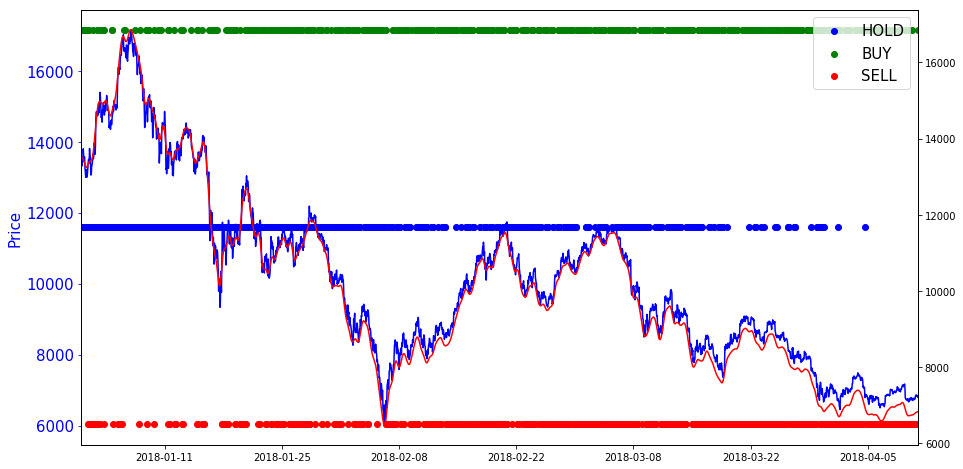

In [16]:
plot_test(test_start, datetime.datetime(2018,4,11,0))

# Save Model (Optional)

In [15]:
# to be implemented.... sorry....

# Always buy agent

In [204]:
from simple_agents import *

In [205]:
always_buy_agent = AlwaysBuyAgent(Action)

In [206]:
env = Environment()
now = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
env.set_current_time(now)
portfolio = Portfolio(cash_supply=1e8)
while True:
    action = always_buy_agent.get_action()
    if (env.current_index - env.start_index) / env.time_delta % 24 == 0:
        verbose = True
        print('Current time:', env.current_index)
    else:
        verbose = False
    current_price = env.getCurrentPrice()
    action = portfolio.apply_action(current_price, action, verbose=verbose)
    is_done, state = env.step()
    if env.current_index == test_end:
        break
print("Initial cash supply:", portfolio.starting_cash)
print("Final holdings:", portfolio.getCurrentHoldings(env.getCurrentPrice()))

Current time: 2017-12-01 13:00:00
Action start: Action.BUY , Total value before action: 101768167.32603675
Before buying: coin:7583.457, cash:25327021.511, buy price:10218.013
After buying: coin bought:247.866, transaction fees:6331.755, coin now:7831.323, cash now:22787987.604
Action end:  Action.BUY , Total value now: 101727623.464.  , Return since entry: 1.728 %

Current time: 2017-12-02 13:00:00
Action start: Action.BUY , Total value before action: 109454130.3945612
Before buying: coin:9763.814, cash:2006821.046, buy price:11155.333
After buying: coin bought:17.990, transaction fees:501.705, coin now:9781.804, cash now:1805637.237
Action end:  Action.BUY , Total value now: 109450917.846.  , Return since entry: 9.451 %

Current time: 2017-12-03 13:00:00
Action start: Action.BUY , Total value before action: 114972193.9853586
Before buying: coin:9931.208, cash:159013.199, buy price:11719.152
After buying: coin bought:1.357, transaction fees:39.753, coin now:9932.564, cash now:143072.1

Current time: 2017-12-30 13:00:00
Action start: Action.BUY , Total value before action: 123570645.59934495
Before buying: coin:9944.905, cash:0.000, buy price:12595.667
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 123570645.599.  , Return since entry: 23.571 %

Current time: 2017-12-31 13:00:00
Action start: Action.BUY , Total value before action: 128366983.95875396
Before buying: coin:9944.905, cash:0.000, buy price:13084.562
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 128366983.959.  , Return since entry: 28.367 %

Initial cash supply: 100000000.0
Final holdings: 9944.90 coins, 0.00 cash, 136306457.98 current value, 36.31 percent returns
